In [1]:
import networkx as nx
import numpy as np
import itertools as it
import random
import time
import scipy
from matplotlib import pyplot as plt
import fresnel
import os
import PIL

In [2]:
np.random.seed(100)
random.seed(100)

In [3]:
def coordination_pattern(x):
    """
    To do: obtain the neighbors of an input atom position
    Args:
        x: the position of atoms
    Returns:
        the neighbors of the atoms, excluding the center atoms
    """
    return np.array([x+np.array([0.5,0.5,0]),
                     x+np.array([-0.5,0.5,0]),
                     x+np.array([0.5,-0.5,0]),
                     x+np.array([-0.5,-0.5,0]),
                     x+np.array([0.5,0,0.5]),
                     x+np.array([0.5,0,-0.5]),
                     x+np.array([-0.5,0,0.5]),
                     x+np.array([-0.5,0,-0.5]),
                     x+np.array([0,0.5,0.5]),
                     x+np.array([0,-0.5,0.5]),
                     x+np.array([0,0.5,-0.5]),
                     x+np.array([0,-0.5,-0.5]),
                    ])
def neighbors(x):
    """
    To do: obtain the occupied sites for a given cell
    Args:
        x: the position of cells
    Returns:
        the occupied sites in the cells
    """
    #define sites of fcc cell where x is the body center
    return np.array([x+np.array([0.5,0,0]),
                     x+np.array([-0.5,0,0]),
                     x+np.array([0,-0.5,0]),
                     x+np.array([0,0.5,0]),
                     x+np.array([0,0,0.5]),
                     x+np.array([0,0,-0.5]),      
                     x+np.array([0.5,0.5,0.5]),
                     x+np.array([-0.5,-0.5,0.5]),
                     x+np.array([0.5,-0.5,0.5]),
                     x+np.array([-0.5,0.5,0.5]),           
                     x+np.array([0.5,0.5,-0.5]),
                     x+np.array([-0.5,-0.5,-0.5]),
                     x+np.array([0.5,-0.5,-0.5]),
                     x+np.array([-0.5,0.5,-0.5])   
                    ])
    

In [4]:
#define the kinetic constant for simulation
k_Au=-4.0
k_Ag=-4.0
Energy_ratio=1.0
Energy_ratio2=1.0
k_on_Au=0.400000
k_on_Ag=1.000000
random_seed = 42

path="/mnt/orkney/Chemobot/Nanobot-Monte_Carlo_Simulation/Au_Ag_7_traj/example_{}_{}_{}_{}_{}_{}_{}/".format(k_Au,k_Ag,Energy_ratio,Energy_ratio2,k_on_Au,k_on_Ag,random_seed)

In [5]:
# read in the initial structure
initial_atom_strucutre = np.loadtxt("/home/yibin/workspace/Growth_with_silverV3/atomList_TruncatedOctahedron.csv",delimiter=",")
initial_atom_strucutre = initial_atom_strucutre-np.array([0.5,0.5,0.5]) # slight movement

In [6]:
# get the trajecotry
count = 500000
site_temp_record_total = np.load(path+"structure/"+"site_temp_record_total%d.npy"%count,allow_pickle = True)
atom_type_record_total = np.load(path+"structure/"+"atom_type_record_total%d.npy"%count,allow_pickle = True)

In [7]:
# calculate the extra atom positions
# slight movement
extra_atom_sites = np.array([site_temp_record_total[i][0] for i in range(len(site_temp_record_total))]) - np.array([0.5,0.5,0.5])
event_indexes = np.array([site_temp_record_total[i][1] for i in range(len(site_temp_record_total))])
# the atomic sites that appeared in the trajecotry should be recorded
final_structure = np.unique(np.vstack((initial_atom_strucutre,extra_atom_sites)),axis=0)

In [8]:
# calculate the potential dipole site position for the given structure 
min_range = np.around(final_structure.min())
max_range = np.around(final_structure.max())
interval = 1.5
sites = min_range+np.arange(int((max_range-min_range)/interval)+3)*interval-interval

dipole_positions = []
for x in sites:
    for y in sites:
        for z in sites:
            dipole_positions.append([x,y,z])
dipole_positions = np.array(dipole_positions)

In [9]:
atom_lower = int(np.floor(dipole_positions.min()))
atom_upper = int(np.ceil(dipole_positions.max()))
ideal_atom_position = []
for x in range(atom_lower,atom_upper+int(3*np.ceil(interval))):
    for y in range(atom_lower,atom_upper+int(3*np.ceil(interval))):
        for z in range(atom_lower,atom_upper+int(3*np.ceil(interval))):
            ideal_atom_position.append([x,y,z])
ideal_atom_position = np.array(ideal_atom_position)
ideal_atom_position = np.unique(neighbors(ideal_atom_position).reshape(-1,3),axis=0).tolist()

In [10]:
# validate all the corresponding atoms were captured by the ideal case
final_structure = final_structure.tolist()
flag = 0
for i in final_structure:
    if not (i in ideal_atom_position):
        print('error!')

In [11]:
# the first output should be the subset of the second output
# the second output should be the subset of the third output
print(f'{np.array(final_structure).min()}_{np.array(final_structure).max()}')
print(f'{np.array(dipole_positions).min()}_{np.array(dipole_positions).max()}')
print(f'{np.array(ideal_atom_position).min()}_{np.array(ideal_atom_position).max()}')

-16.0_33.0
-17.5_33.5
-18.5_39.5


# Check fully occupied atom numbers

In [ ]:
# get the fully occupied dipole number for the ideal case
dipole_full_number = [] # calculate with the ideal atomic position
dipole_full_number2 = [] # directly calculated by the atoms between dipoles
# iterate through all the existing dipole positions
for dipole_position_temp in dipole_positions:
    lower = np.floor(dipole_position_temp)
    upper = np.ceil(dipole_position_temp+interval)
    position = []
    for x in range(int(lower[0]),int(upper[0])+1):
        for y in range(int(lower[1]),int(upper[1])+1):
            for z in range(int(lower[2]),int(upper[2])+1):
                position.append([x,y,z])
    position = np.unique(neighbors(position).reshape(-1,3),axis=0)
    in_dipole_interval = np.all((dipole_position_temp<=position)*(position<=dipole_position_temp+interval),axis=1)
    position = position[in_dipole_interval]
    dipole_full_number.append(sum([i.tolist() in ideal_atom_position for i in position]))
    dipole_full_number2.append(len(position))

In [ ]:
sum(abs(np.array(dipole_full_number)-32))
# this indicates the cell contains 32 dipoles to fill it up

# Get the dipoles that get involved in the whole transformation process

In [12]:
# get the fully occupied dipole number for the ideal case
dipole_current_coord = []
# iterate through all the existing dipole positions
for dipole_position_temp in dipole_positions:
    lower = np.floor(dipole_position_temp)
    upper = np.ceil(dipole_position_temp+interval)
    position = []
    for x in range(int(lower[0]),int(upper[0])+1):
        for y in range(int(lower[1]),int(upper[1])+1):
            for z in range(int(lower[2]),int(upper[2])+1):
                position.append([x,y,z])
    position = np.unique(neighbors(position).reshape(-1,3),axis=0)
    in_dipole_interval = np.all((dipole_position_temp<=position)*(position<=dipole_position_temp+interval),axis=1)
    position = position[in_dipole_interval]
    dipole_current_coord.append(sum([i.tolist() in final_structure for i in position]))

In [13]:
dipole_positions = dipole_positions[np.array(dipole_current_coord)==32]

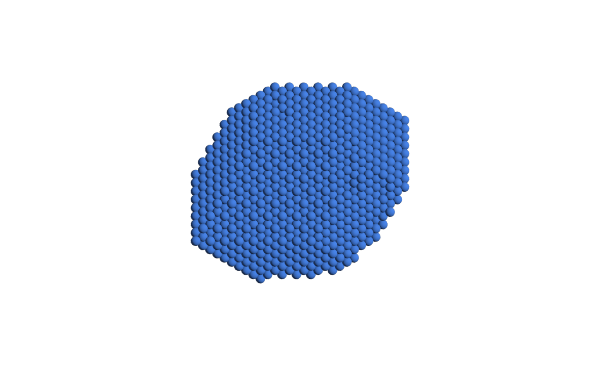

In [14]:
scene = fresnel.Scene()
geometry1 = fresnel.geometry.Sphere(scene, N=len(dipole_positions), radius=np.sqrt(2)/2)
geometry1.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]),
                                              roughness=0.8)

geometry1.position[:] = dipole_positions
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

In [15]:
print(len(dipole_positions))

3753


# Initialize the atom coordinates

In [16]:
initial_atom_strucutre = initial_atom_strucutre.tolist()
# get the fully occupied dipole number for the ideal case
dipole_current_coord = []
# iterate through all the existing dipole positions
for dipole_position_temp in dipole_positions:
    lower = np.floor(dipole_position_temp)
    upper = np.ceil(dipole_position_temp+interval)
    position = []
    for x in range(int(lower[0]),int(upper[0])+1):
        for y in range(int(lower[1]),int(upper[1])+1):
            for z in range(int(lower[2]),int(upper[2])+1):
                position.append([x,y,z])
    position = np.unique(neighbors(position).reshape(-1,3),axis=0)
    in_dipole_interval = np.all((dipole_position_temp<=position)*(position<=dipole_position_temp+interval),axis=1)
    position = position[in_dipole_interval]
    dipole_current_coord.append(sum([i.tolist() in initial_atom_strucutre for i in position]))

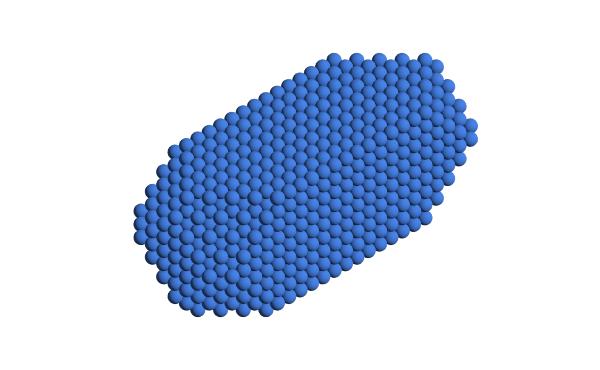

In [17]:
scene = fresnel.Scene()
geometry1 = fresnel.geometry.Sphere(scene, N=len(dipole_positions[np.array(dipole_current_coord)==32]), radius=np.sqrt(2)/2)
geometry1.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]),
                                              roughness=0.8)

geometry1.position[:] = dipole_positions[np.array(dipole_current_coord)==32]
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

In [18]:
print(len(dipole_positions))

3753


In [19]:
np.savetxt(f'./dipole_positions_{random_seed}.csv',dipole_positions,delimiter=',')
np.savetxt(f'./dipole_current_coord_{random_seed}.csv',dipole_current_coord,delimiter=',')

# Loop through the event

In [20]:
# read in the generated dipole position
dipole_positions = np.loadtxt(f'./dipole_positions_{random_seed}.csv',delimiter=',')
# read in the calculated atom number inside the dipoles
dipole_current_coord = np.loadtxt(f'./dipole_current_coord_{random_seed}.csv',delimiter=',')
# get the trajecotry information
count = 500000
site_temp_record_total = np.load(path+"structure/"+"site_temp_record_total%d.npy"%count,allow_pickle = True)
atom_type_record_total = np.load(path+"structure/"+"atom_type_record_total%d.npy"%count,allow_pickle = True)
# calculate the extra atom positions
# slight movement
extra_atom_sites = np.array([site_temp_record_total[i][0] for i in range(len(site_temp_record_total))]) - np.array([0.5,0.5,0.5])
event_indexes = np.array([site_temp_record_total[i][1] for i in range(len(site_temp_record_total))])

In [21]:
# get the number of Au/Ag atoms in the dipole
coord_infor = {}
count = 0
for dipole_position_temp in dipole_positions:
    coord_infor[tuple(dipole_position_temp)] = {}
    coord_infor[tuple(dipole_position_temp)]['coord'] = [dipole_current_coord[count],0]
    if sum(coord_infor[tuple(dipole_position_temp)]['coord']) == 32:
        coord_infor[tuple(dipole_position_temp)]['type'] = 'dipole'
    else:
        coord_infor[tuple(dipole_position_temp)]['type'] = 'vacant'
    count = count + 1
dipole_positions = dipole_positions.tolist()

In [22]:
np.random.seed(random_seed)
events = []
# get the change of the nanostructures through the atomic changes
for i in range(len(extra_atom_sites)):
    extra_atom_site_tmp = extra_atom_sites[i]
    # get the sites that is involved by this atomic site
    dipole_site = []
    site_x = sites[(sites>=(extra_atom_site_tmp[0] - interval))*(sites<=(extra_atom_site_tmp[0]))]
    site_y = sites[(sites>=(extra_atom_site_tmp[1] - interval))*(sites<=(extra_atom_site_tmp[1]))]
    site_z = sites[(sites>=(extra_atom_site_tmp[2] - interval))*(sites<=(extra_atom_site_tmp[2]))]
    for x in site_x:
        for y in site_y:
            for z in site_z:
                dipole_site.append([x,y,z])
    np.random.shuffle(dipole_site)
                
    if event_indexes[i] == 0:
        # addition event
        for dipole_site_temp in dipole_site:
            if dipole_site_temp in dipole_positions:
                if atom_type_record_total[i] == 'Au':
                    coord_infor[tuple(dipole_site_temp)]['coord'][0] = coord_infor[tuple(dipole_site_temp)]['coord'][0] + 1
                else:
                    coord_infor[tuple(dipole_site_temp)]['coord'][1] = coord_infor[tuple(dipole_site_temp)]['coord'][1] + 1
                # judge if a new dipole should be added after the addition event
                if coord_infor[tuple(dipole_site_temp)]['coord'][0] + coord_infor[tuple(dipole_site_temp)]['coord'][1] ==32:
                    events.append([dipole_site_temp,
                                   coord_infor[tuple(dipole_site_temp)]['coord'].copy(),
                                   'add',
                                   atom_type_record_total[i]])
                    print(i)
                    coord_infor[tuple(dipole_site_temp)]['type']='dipole'
                            
    # replacement
    elif event_indexes[i] == 1:
        for dipole_site_temp in dipole_site:
            if dipole_site_temp in dipole_positions:
                if atom_type_record_total[i] == 'Au':
                    # judge the event type and atom type
                    coord_infor[tuple(dipole_site_temp)]['coord'][0] = coord_infor[tuple(dipole_site_temp)]['coord'][0] - 1
                    coord_infor[tuple(dipole_site_temp)]['coord'][1] = coord_infor[tuple(dipole_site_temp)]['coord'][1] + 1
                else:
                    # judge the event type and atom type
                    coord_infor[tuple(dipole_site_temp)]['coord'][0] = coord_infor[tuple(dipole_site_temp)]['coord'][0] + 1
                    coord_infor[tuple(dipole_site_temp)]['coord'][1] = coord_infor[tuple(dipole_site_temp)]['coord'][1] - 1
                    
                if coord_infor[tuple(dipole_site_temp)]['coord'][0] + coord_infor[tuple(dipole_site_temp)]['coord'][1] ==32:
                    # Replace the Au dipole with Ag dipole
                    events.append([dipole_site_temp,
                                   coord_infor[tuple(dipole_site_temp)]['coord'].copy(),
                                   'replace',
                                   atom_type_record_total[i]])
                    print(i)
    else:
        # deletion event
        for dipole_site_temp in dipole_site:
            if dipole_site_temp in dipole_positions:
                # judge the event type and atom type
                if atom_type_record_total[i] == 'Au':
                    coord_infor[tuple(dipole_site_temp)]['coord'][0] = coord_infor[tuple(dipole_site_temp)]['coord'][0] - 1
                else:
                    coord_infor[tuple(dipole_site_temp)]['coord'][1] = coord_infor[tuple(dipole_site_temp)]['coord'][1] - 1
                if coord_infor[tuple(dipole_site_temp)]['type'] != 'vacant':
                    events.append([dipole_site_temp,
                                   coord_infor[tuple(dipole_site_temp)]['coord'].copy(),
                                   'delete',
                                   atom_type_record_total[i]])
                    coord_infor[tuple(dipole_site_temp)]['type'] = 'vacant'
                    print(i)

2
2
3
3
8
20
30
30
44
44
66
73
76
76
79
86
86
88
92
98
98
100
105
105
105
105
108
115
115
118
118
119
121
122
127
127
127
127
130
130
148
151
151
151
154
161
164
166
169
170
170
170
171
171
176
176
177
185
193
197
197
199
200
202
202
202
202
209
211
212
219
223
223
238
238
241
241
250
250
253
255
259
262
271
272
279
279
283
284
291
291
296
296
296
299
304
304
308
317
317
317
324
324
324
324
325
328
330
330
330
330
336
337
341
352
352
356
360
370
370
375
383
386
386
395
399
399
402
403
409
416
416
416
416
424
426
429
431
431
437
437
437
437
462
464
464
467
478
484
484
485
493
493
498
498
507
511
520
523
523
526
537
538
544
545
548
548
555
555
564
571
571
573
574
585
587
587
592
592
597
602
602
604
609
609
611
616
616
617
619
623
624
636
639
639
640
642
642
654
655
655
670
670
670
670
671
680
680
680
690
693
695
695
695
698
699
701
701
707
708
708
720
720
720
726
726
729
731
735
738
741
744
744
753
757
757
760
765
769
771
780
800
800
800
800
804
806
812
812
822
822
823
823
823
823
826
82

5793
5794
5802
5802
5806
5808
5808
5810
5811
5811
5813
5813
5813
5813
5826
5853
5855
5857
5857
5881
5886
5888
5897
5921
5921
5925
5927
5936
5936
5947
5947
5949
5964
5966
5966
5966
5966
5974
5974
5978
5978
5979
5979
5982
5982
5999
6000
6006
6006
6008
6009
6009
6012
6021
6021
6031
6031
6031
6031
6033
6034
6045
6045
6059
6064
6065
6069
6072
6083
6089
6095
6097
6097
6111
6122
6126
6127
6131
6131
6131
6131
6132
6136
6136
6139
6148
6149
6152
6155
6155
6159
6170
6175
6176
6181
6181
6196
6202
6215
6215
6216
6216
6217
6217
6217
6217
6219
6219
6219
6219
6229
6235
6238
6239
6241
6252
6253
6254
6259
6259
6262
6262
6271
6277
6277
6277
6277
6282
6287
6289
6295
6295
6301
6303
6303
6309
6312
6318
6318
6319
6319
6323
6323
6323
6333
6333
6347
6359
6373
6380
6385
6386
6387
6390
6390
6398
6403
6407
6410
6421
6421
6422
6429
6429
6433
6441
6441
6443
6447
6447
6454
6458
6458
6461
6461
6462
6462
6470
6471
6471
6473
6476
6476
6478
6485
6486
6486
6486
6486
6493
6494
6494
6494
6494
6496
6501
6501
6503
6503
6503


12472
12472
12478
12481
12483
12486
12496
12496
12499
12499
12505
12508
12508
12536
12536
12540
12565
12568
12568
12576
12594
12594
12595
12602
12602
12604
12609
12619
12630
12630
12636
12637
12638
12640
12640
12643
12643
12652
12666
12668
12672
12674
12680
12688
12692
12701
12704
12708
12708
12708
12709
12723
12728
12737
12749
12768
12768
12793
12794
12801
12802
12802
12802
12802
12808
12814
12817
12817
12824
12838
12861
12868
12880
12895
12916
12931
12943
12943
12943
12947
12947
12951
12951
12959
12971
12976
12976
12977
12986
12991
12991
13001
13006
13006
13007
13033
13040
13042
13049
13050
13050
13050
13058
13058
13067
13067
13075
13082
13095
13103
13116
13116
13118
13120
13128
13128
13129
13141
13141
13141
13141
13164
13164
13164
13164
13178
13179
13190
13190
13202
13204
13204
13218
13222
13224
13224
13230
13246
13246
13255
13263
13266
13267
13271
13271
13277
13285
13289
13290
13297
13299
13300
13302
13316
13321
13325
13328
13328
13331
13331
13345
13348
13351
13380
13381
13392
1339

20710
20716
20749
20749
20763
20763
20783
20791
20796
20801
20815
20815
20824
20824
20828
20833
20835
20847
20847
20870
20872
20880
20882
20882
20884
20886
20892
20892
20897
20897
20897
20903
20905
20929
20929
20938
20940
20941
20952
20952
20952
20952
20962
20962
20966
20967
20971
20971
20976
21000
21007
21022
21042
21042
21053
21057
21057
21058
21064
21080
21080
21082
21083
21086
21095
21095
21107
21108
21108
21116
21116
21122
21135
21164
21169
21169
21174
21178
21178
21196
21202
21203
21203
21215
21276
21301
21303
21303
21303
21303
21304
21306
21310
21325
21327
21335
21341
21346
21351
21360
21362
21391
21414
21414
21426
21443
21449
21449
21452
21453
21458
21461
21466
21476
21482
21483
21486
21500
21501
21518
21537
21537
21548
21593
21593
21605
21628
21632
21640
21648
21650
21650
21655
21661
21662
21670
21712
21712
21712
21716
21716
21716
21716
21719
21733
21734
21737
21738
21738
21754
21755
21765
21772
21777
21777
21782
21785
21807
21807
21807
21807
21809
21809
21817
21824
21856
2186

32562
32571
32574
32574
32581
32593
32599
32599
32599
32600
32611
32611
32611
32611
32632
32632
32650
32661
32668
32676
32695
32695
32716
32717
32726
32728
32730
32740
32740
32741
32742
32748
32749
32757
32757
32776
32780
32783
32800
32807
32813
32817
32818
32832
32840
32840
32841
32841
32852
32860
32862
32923
32942
32963
32970
32971
32975
32978
32993
32996
33001
33003
33004
33007
33022
33024
33027
33031
33034
33039
33042
33051
33053
33053
33058
33058
33060
33083
33085
33087
33101
33115
33118
33130
33132
33135
33139
33139
33141
33142
33143
33171
33183
33183
33184
33184
33194
33198
33207
33219
33219
33219
33221
33227
33243
33246
33246
33247
33249
33249
33254
33256
33258
33271
33276
33276
33283
33287
33287
33293
33301
33301
33309
33324
33341
33350
33351
33369
33379
33379
33381
33402
33402
33404
33438
33440
33451
33451
33455
33455
33466
33467
33471
33471
33471
33471
33476
33477
33481
33484
33504
33525
33529
33529
33529
33533
33567
33571
33577
33578
33585
33585
33590
33598
33606
33606
3360

40814
40817
40835
40837
40861
40864
40886
40886
40890
40897
40897
40917
40917
40922
40927
40931
40931
40935
40936
40945
40946
40947
40947
40950
40962
40963
40967
40971
40973
40977
40978
40980
40981
40984
41005
41010
41012
41012
41014
41017
41023
41025
41026
41030
41036
41042
41047
41047
41048
41048
41066
41073
41078
41083
41083
41083
41083
41098
41106
41111
41143
41151
41151
41152
41154
41154
41166
41181
41181
41182
41190
41193
41198
41199
41201
41201
41214
41225
41225
41227
41230
41232
41240
41244
41252
41254
41258
41258
41258
41266
41270
41273
41283
41296
41304
41312
41313
41315
41321
41327
41327
41336
41340
41344
41344
41346
41346
41346
41348
41361
41361
41364
41386
41399
41399
41400
41400
41424
41443
41460
41470
41473
41473
41477
41486
41498
41501
41504
41506
41514
41532
41535
41535
41535
41537
41542
41542
41547
41565
41568
41569
41569
41569
41580
41587
41595
41596
41600
41603
41604
41608
41614
41620
41633
41641
41642
41645
41655
41666
41667
41679
41690
41690
41695
41695
41697
4170

50632
50632
50638
50672
50672
50674
50676
50676
50680
50682
50696
50715
50730
50736
50739
50745
50745
50745
50745
50751
50752
50758
50773
50774
50774
50800
50830
50831
50862
50864
50865
50869
50885
50900
50905
50916
50917
50918
50918
50918
50931
50948
50957
50963
50965
50972
50983
51020
51026
51037
51044
51063
51063
51066
51068
51070
51092
51111
51112
51116
51121
51127
51127
51132
51132
51137
51140
51145
51151
51152
51152
51175
51184
51186
51202
51208
51214
51214
51217
51218
51223
51224
51240
51246
51272
51292
51295
51296
51307
51341
51353
51353
51354
51376
51385
51392
51396
51399
51417
51419
51420
51421
51451
51472
51480
51482
51483
51496
51496
51501
51504
51533
51533
51533
51533
51537
51538
51540
51540
51570
51578
51579
51607
51631
51655
51667
51683
51684
51688
51688
51694
51695
51697
51699
51701
51702
51705
51712
51716
51717
51724
51728
51737
51739
51746
51749
51750
51753
51756
51757
51758
51770
51801
51805
51814
51816
51830
51836
51846
51847
51851
51861
51883
51896
51914
51918
5191

60221
60232
60238
60247
60251
60252
60252
60255
60257
60262
60264
60266
60271
60294
60300
60306
60309
60309
60310
60316
60330
60332
60351
60365
60368
60371
60379
60382
60389
60389
60411
60411
60420
60420
60423
60427
60429
60429
60429
60429
60435
60443
60447
60449
60449
60449
60450
60451
60451
60452
60454
60466
60475
60478
60485
60489
60514
60514
60515
60515
60515
60523
60523
60526
60530
60530
60535
60547
60567
60577
60591
60593
60593
60598
60598
60599
60605
60607
60607
60610
60614
60614
60631
60631
60632
60641
60648
60682
60683
60684
60688
60688
60688
60688
60717
60719
60722
60726
60726
60728
60729
60730
60738
60738
60742
60752
60755
60770
60809
60809
60819
60827
60839
60843
60849
60851
60864
60865
60868
60873
60878
60903
60921
60936
60949
60954
60969
60973
60977
60985
61000
61003
61007
61010
61010
61011
61014
61015
61024
61026
61027
61041
61041
61046
61047
61056
61057
61063
61063
61069
61071
61073
61083
61084
61103
61106
61110
61120
61123
61123
61124
61134
61136
61139
61157
61159
6115

68592
68595
68600
68602
68603
68610
68613
68616
68636
68646
68668
68669
68673
68695
68705
68709
68709
68723
68730
68730
68730
68734
68734
68743
68765
68779
68787
68792
68792
68799
68799
68804
68806
68806
68806
68806
68813
68819
68837
68838
68840
68873
68877
68887
68887
68898
68902
68904
68915
68924
68932
68940
68958
68958
68959
68959
68960
68977
68978
68982
68984
68990
68990
68997
68999
69014
69022
69037
69042
69045
69062
69072
69111
69115
69115
69115
69115
69139
69140
69140
69140
69141
69146
69171
69181
69183
69195
69212
69231
69233
69240
69251
69251
69260
69268
69270
69277
69277
69277
69281
69281
69285
69307
69320
69320
69324
69355
69357
69361
69369
69369
69382
69384
69405
69420
69434
69436
69436
69437
69437
69437
69442
69443
69444
69448
69455
69466
69476
69476
69486
69487
69490
69490
69490
69490
69506
69510
69515
69521
69532
69537
69554
69577
69581
69581
69592
69599
69620
69620
69635
69644
69649
69649
69655
69670
69683
69698
69706
69711
69713
69728
69730
69747
69768
69775
69776
6978

78679
78688
78688
78688
78688
78701
78710
78710
78714
78722
78722
78722
78722
78752
78753
78765
78775
78785
78800
78813
78816
78816
78821
78827
78827
78831
78854
78856
78864
78866
78877
78882
78882
78893
78901
78901
78904
78910
78910
78920
78934
78935
78955
78989
79015
79028
79030
79032
79039
79039
79045
79046
79057
79062
79083
79085
79109
79112
79116
79117
79134
79138
79138
79141
79142
79143
79143
79143
79143
79146
79155
79162
79171
79206
79207
79214
79217
79219
79229
79233
79233
79235
79236
79236
79247
79258
79264
79269
79286
79290
79296
79303
79309
79309
79309
79314
79328
79333
79343
79355
79370
79373
79377
79378
79378
79378
79378
79381
79381
79381
79386
79386
79391
79404
79406
79407
79418
79418
79420
79426
79444
79456
79456
79461
79468
79477
79487
79487
79509
79509
79519
79548
79551
79569
79569
79579
79583
79589
79591
79591
79595
79598
79600
79600
79611
79624
79637
79640
79652
79657
79661
79661
79664
79668
79685
79685
79690
79705
79711
79711
79711
79716
79716
79733
79740
79749
7975

88056
88058
88058
88069
88069
88084
88090
88092
88097
88097
88099
88109
88109
88114
88120
88120
88120
88131
88136
88136
88143
88145
88145
88149
88152
88152
88159
88177
88183
88237
88249
88267
88268
88268
88272
88273
88273
88276
88277
88288
88288
88289
88312
88315
88317
88322
88343
88410
88416
88418
88430
88430
88434
88434
88440
88446
88447
88451
88454
88461
88486
88486
88498
88499
88499
88502
88503
88504
88507
88518
88519
88519
88520
88520
88521
88521
88528
88561
88566
88572
88573
88595
88598
88603
88618
88642
88648
88654
88664
88694
88696
88696
88696
88697
88706
88751
88760
88768
88780
88784
88789
88790
88794
88805
88827
88834
88859
88860
88887
88891
88891
88919
88923
88928
88946
88955
88956
88964
88981
88984
88993
88996
89001
89009
89024
89026
89027
89028
89033
89042
89053
89054
89056
89063
89065
89076
89079
89089
89094
89096
89106
89124
89133
89133
89143
89154
89156
89157
89162
89170
89172
89173
89188
89209
89218
89221
89223
89227
89237
89244
89244
89245
89247
89251
89261
89273
8927

97427
97431
97431
97437
97442
97448
97462
97470
97489
97508
97533
97533
97533
97543
97559
97565
97589
97598
97602
97611
97625
97632
97641
97648
97649
97652
97653
97654
97658
97659
97660
97675
97679
97681
97685
97685
97685
97699
97707
97722
97726
97727
97728
97731
97763
97764
97766
97769
97790
97791
97792
97801
97801
97805
97805
97811
97811
97811
97813
97815
97815
97830
97830
97830
97843
97847
97857
97872
97888
97892
97892
97892
97906
97921
97929
97933
97935
97938
97939
97941
97945
97945
97946
97958
97959
97963
97982
97997
98006
98017
98020
98020
98023
98028
98040
98046
98047
98053
98053
98066
98071
98071
98071
98077
98087
98094
98096
98128
98129
98129
98133
98148
98153
98160
98163
98163
98163
98165
98166
98170
98180
98198
98210
98216
98217
98240
98240
98240
98246
98259
98262
98262
98263
98266
98286
98304
98305
98306
98313
98322
98328
98345
98345
98348
98348
98353
98374
98382
98407
98410
98412
98415
98415
98418
98433
98433
98433
98454
98454
98454
98454
98482
98487
98487
98494
98494
9850

In [23]:
np.save(f'./event_{random_seed}.npy',events)

/home/yibin/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [24]:
import pickle
with open(f'./coord_infor_{random_seed}.pickle', 'wb') as handle:
    pickle.dump(coord_infor, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
events

[[[-4.0, -2.5, 26.0], [31.0, 1], 'replace', 'Au'],
 [[-2.5, -2.5, 26.0], [31.0, 1], 'replace', 'Au'],
 [[-2.5, -8.5, 14.0], [31.0, 1], 'replace', 'Au'],
 [[-2.5, -8.5, 12.5], [31.0, 1], 'replace', 'Au'],
 [[-5.5, -8.5, 5.0], [31.0, 1], 'replace', 'Au'],
 [[0.5, 2.0, 26.0], [31.0, 1], 'replace', 'Au'],
 [[-8.5, -4.0, -1.0], [31.0, 1], 'replace', 'Au'],
 [[-8.5, -4.0, -2.5], [31.0, 1], 'replace', 'Au'],
 [[-5.5, -8.5, 18.5], [31.0, 1], 'replace', 'Au'],
 [[-4.0, -8.5, 18.5], [31.0, 1], 'replace', 'Au'],
 [[-1.0, -8.5, 11.0], [31.0, 1], 'replace', 'Au'],
 [[-8.5, 3.5, 14.0], [31.0, 1], 'replace', 'Au'],
 [[-1.0, -8.5, 17.0], [31.0, 1], 'replace', 'Au'],
 [[-2.5, -8.5, 17.0], [31.0, 1], 'replace', 'Au'],
 [[-8.5, 3.5, 9.5], [31.0, 1], 'replace', 'Au'],
 [[-5.5, -8.5, 14.0], [31.0, 1], 'replace', 'Au'],
 [[-5.5, -8.5, 15.5], [31.0, 1], 'replace', 'Au'],
 [[-1.0, -2.5, -8.5], [31.0, 1], 'replace', 'Au'],
 [[5.0, -7.0, 18.5], [31.0, 1], 'replace', 'Au'],
 [[-8.5, -2.5, 20.0], [31.0, 1], 'repl

In [26]:
len(events)

16894